# Incidence de la varicelle

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
import os.path
import numpy

Les données de l'incidence du syndrome grippal sont disponibles du site Web du [Réseau Sentinelles](http://www.sentiweb.fr/). Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1984 et se termine avec une semaine récente.

In [2]:
data_url   = "http://www.sentiweb.fr/datasets/incidence-PAY-7.csv"
local_file = "data.csv"

In [3]:
if not os.path.isfile(local_file):
    print("Téléchargement du fichier de données...")
    pd.read_csv(data_url, skiprows=1).to_csv('data.csv')

Voici l'explication des colonnes données [sur le site d'origine](https://ns.sentiweb.fr/incidence/csv-schema-v1.json):

| Name         | Type    | Description                                                                                                               |
|:-------------|:--------|:--------------------------------------------------------------------------------------------------------------------------|
| week PK      | integer | ISO8601 Yearweek number as numeric (year*100 + week nubmer)                                                               |
| geo_insee PK | string  | Identifier of the geographic area, from INSEE https://www.insee.fr                                                        |
| geo_name     | string  | Geographic label of the area, corresponding to INSEE code. This label is not an id and is only provided for human reading |
| indicator PK | integer | Unique identifier of the indicator, see metadata document https://www.sentiweb.fr/meta.json                               |
| inc          | integer | Estimated incidence value for the time step, in the geographic level                                                      |
| inc_low      | integer | Lower bound of the estimated incidence 95% Confidence Interval                                                            |
| inc_up       | integer | Upper bound of the estimated incidence 95% Confidence Interval                                                            |
| inc100       | integer | Estimated rate incidence per 100,000 inhabitants                                                                          |
| inc100_low   | integer | Lower bound of the estimated incidence 95% Confidence Interval                                                            |
| inc100_up    | integer | Upper bound of the estimated rate incidence 95% Confidence Interval                                                       |

In [4]:
raw_data = pd.read_csv(local_file)
raw_data

Unnamed: 0    week  indicator    inc  inc_low  inc_up  inc100  \
0              0  202013          7   7371     5268    9474      11   
1              1  202012          7   8123     5790   10456      12   
2              2  202011          7  10198     7568   12828      15   
3              3  202010          7   9011     6691   11331      14   
4              4  202009          7  13631    10544   16718      21   
5              5  202008          7  10424     7708   13140      16   
6              6  202007          7   8959     6574   11344      14   
7              7  202006          7   9264     6925   11603      14   
8              8  202005          7   8505     6314   10696      13   
9              9  202004          7   7991     5831   10151      12   
10            10  202003          7   5968     4100    7836       9   
11            11  202002          7   6534     4530    8538      10   
12            12  202001          7   9835     7019   12651      15   
13            13  201952          7   7941     5246   10636      12   
14            14  201951          7   5823     3675    7971       9   
15            15  201950          7   6424     4276    8572      10   
16            16  201949          7   6621     4540    8702      10   
17            17  201948          7   5542     3383    7701       8   
18            18  201947          7   7536     5058   10014      11   
19            19  201946          7   2638     1316    3960       4   
20            20  201945          7   4492     2615    6369       7   
21            21  201944          7   5728     3627    7829       9   
22            22  201943          7   4834     2751    6917       7   
23            23  201942          7   6279     3989    8569      10   
24            24  201941          7   4130     2030    6230       6   
25            25  201940          7   4211     2218    6204       6   
26            26  201939          7   3137     1310    4964       5   
27            27  201938          7   3078     1416    4740       5   
28            28  201937          7    970      162    1778       1   
29            29  201936          7   1277      263    2291       2   
...          ...     ...        ...    ...      ...     ...     ...   
1500        1500  199126          7  17608    11304   23912      31   
1501        1501  199125          7  16169    10700   21638      28   
1502        1502  199124          7  16171    10071   22271      28   
1503        1503  199123          7  11947     7671   16223      21   
1504        1504  199122          7  15452     9953   20951      27   
1505        1505  199121          7  14903     8975   20831      26   
1506        1506  199120          7  19053    12742   25364      34   
1507        1507  199119          7  16739    11246   22232      29   
1508        1508  199118          7  21385    13882   28888      38   
1509        1509  199117          7  13462     8877   18047      24   
1510        1510  199116          7  14857    10068   19646      26   
1511        1511  199115          7  13975     9781   18169      25   
1512        1512  199114          7  12265     7684   16846      22   
1513        1513  199113          7   9567     6041   13093      17   
1514        1514  199112          7  10864     7331   14397      19   
1515        1515  199111          7  15574    11184   19964      27   
1516        1516  199110          7  16643    11372   21914      29   
1517        1517  199109          7  13741     8780   18702      24   
1518        1518  199108          7  13289     8813   17765      23   
1519        1519  199107          7  12337     8077   16597      22   
1520        1520  199106          7  10877     7013   14741      19   
1521        1521  199105          7  10442     6544   14340      18   
1522        1522  199104          7   7913     4563   11263      14   
1523        1523  199103          7  15387    10484   20290      27   
1524        1524  199102      

In [5]:
(raw_data == '-').any(axis=1).any()

False

Il n'y a aucun point manquant dans ce jeu de données. Nous poursuivons donc l'analyse avec le jeu de données complet.

In [6]:
data = raw_data

Nos données utilisent une convention inhabituelle: le numéro de
semaine est collé à l'année, donnant l'impression qu'il s'agit
de nombre entier. C'est comme ça que Pandas les interprète.
  
Un deuxième problème est que Pandas ne comprend pas les numéros de
semaine.  Il faut lui fournir les dates de début et de fin de
semaine. Nous utilisons pour cela la bibliothèque `isoweek`.

Comme la conversion des semaines est devenu assez complexe, nous
écrivons une petite fonction Python pour cela. Ensuite, nous
l'appliquons à tous les points de nos donnés. Les résultats vont
dans une nouvelle colonne 'period'.

In [7]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

Il restent deux petites modifications à faire.

Premièrement, nous définissons les périodes d'observation
comme nouvel index de notre jeux de données. Ceci en fait
une suite chronologique, ce qui sera pratique par la suite.

Deuxièmement, nous trions les points par période, dans
le sens chronologique.

In [8]:
sorted_data = data.set_index('period').sort_index()
sorted_data

Unnamed: 0    week  indicator    inc  inc_low  inc_up  \
period                                                                         
1990-12-03/1990-12-09        1529  199049          7   1143        0    2610   
1990-12-10/1990-12-16        1528  199050          7  11079     6660   15498   
1990-12-17/1990-12-23        1527  199051          7  19080    13807   24353   
1990-12-24/1990-12-30        1526  199052          7  19375    13295   25455   
1990-12-31/1991-01-06        1525  199101          7  15565    10271   20859   
1991-01-07/1991-01-13        1524  199102          7  16277    11046   21508   
1991-01-14/1991-01-20        1523  199103          7  15387    10484   20290   
1991-01-21/1991-01-27        1522  199104          7   7913     4563   11263   
1991-01-28/1991-02-03        1521  199105          7  10442     6544   14340   
1991-02-04/1991-02-10        1520  199106          7  10877     7013   14741   
1991-02-11/1991-02-17        1519  199107          7  12337     8077   16597   
1991-02-18/1991-02-24        1518  199108          7  13289     8813   17765   
1991-02-25/1991-03-03        1517  199109          7  13741     8780   18702   
1991-03-04/1991-03-10        1516  199110          7  16643    11372   21914   
1991-03-11/1991-03-17        1515  199111          7  15574    11184   19964   
1991-03-18/1991-03-24        1514  199112          7  10864     7331   14397   
1991-03-25/1991-03-31        1513  199113          7   9567     6041   13093   
1991-04-01/1991-04-07        1512  199114          7  12265     7684   16846   
1991-04-08/1991-04-14        1511  199115          7  13975     9781   18169   
1991-04-15/1991-04-21        1510  199116          7  14857    10068   19646   
1991-04-22/1991-04-28        1509  199117          7  13462     8877   18047   
1991-04-29/1991-05-05        1508  199118          7  21385    13882   28888   
1991-05-06/1991-05-12        1507  199119          7  16739    11246   22232   
1991-05-13/1991-05-19        1506  199120          7  19053    12742   25364   
1991-05-20/1991-05-26        1505  199121          7  14903     8975   20831   
1991-05-27/1991-06-02        1504  199122          7  15452     9953   20951   
1991-06-03/1991-06-09        1503  199123          7  11947     7671   16223   
1991-06-10/1991-06-16        1502  199124          7  16171    10071   22271   
1991-06-17/1991-06-23        1501  199125          7  16169    10700   21638   
1991-06-24/1991-06-30        1500  199126          7  17608    11304   23912   
...                           ...     ...        ...    ...      ...     ...   
2019-09-02/2019-09-08          29  201936          7   1277      263    2291   
2019-09-09/2019-09-15          28  201937          7    970      162    1778   
2019-09-16/2019-09-22          27  201938          7   3078     1416    4740   
2019-09-23/2019-09-29          26  201939          7   3137     1310    4964   
2019-09-30/2019-10-06          25  201940          7   4211     2218    6204   
2019-10-07/2019-10-13          24  201941          7   4130     2030    6230   
2019-10-14/2019-10-20          23  201942          7   6279     3989    8569   
2019-10-21/2019-10-27          22  201943          7   4834     2751    6917   
2019-10-28/2019-11-03          21  201944          7   5728     3627    7829   
2019-11-04/2019-11-10          20  201945          7   4492     2615    6369   
2019-11-11/2019-11-17          19  201946          7   2638     1316    3960   
2019-11-18/2019-11-24          18  201947          7   7536     5058   10014   
2019-11-25/2019-12-01          17  201948          7   5542     3383    7701   
2019-12-02/2019-12-08          16  201949          7   6621     4540    8702   
2019-12-09/2019-12-15          15  201950          7   6424     4276    8572   
2019-12-16/2019-12-22          14  201951          7   5823     3675    7971   
2019-12-23/2019-12-29          13  201952          7   7941     5246   10636   
2019-12-30/2020-01-05  

Nous vérifions la cohérence des données. Entre la fin d'une période et
le début de la période qui suit, la différence temporelle doit être
zéro, ou au moins très faible. Nous laissons une "marge d'erreur"
d'une seconde.

Ceci permet de vérifier qu'il n'y a pas de "trou" dans les données :

In [9]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

Un premier regard sur les données !

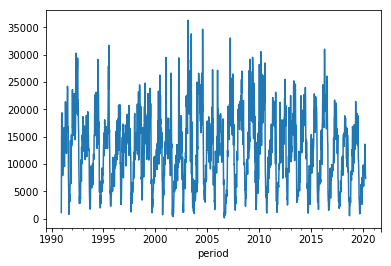

In [10]:
sorted_data['inc'].plot()

Un zoom sur les dernières années montre mieux la situation, avec un creux des incidences chaque année en septembre.

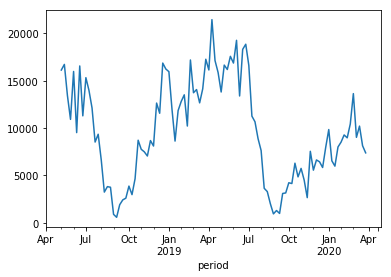

In [11]:
sorted_data['inc'][-100:].plot()

## Etude de l'incidence annuelle

Etant donné que le pic de l'épidémie se situe en hiver, à cheval
entre deux années civiles, nous définissons la période de référence
entre deux minima de l'incidence, du 1er septembre de l'année $N$ au
1er septembre de l'année $N+1$.

Notre tâche est un peu compliquée par le fait que l'année ne comporte
pas un nombre entier de semaines. Nous modifions donc un peu nos périodes
de référence: à la place du 1er septembre de chaque année, nous utilisons le
premier jour de la semaine qui contient le 1er août.

Comme l'incidence de syndrome grippal est très faible en septembre, on limite ainsi le risque de fausser nos conclusions.

Encore un petit détail: les données commencent en décembre 1990, ce qui
rend la première année incomplète. Nous commençons donc l'analyse en 1991. L'année en cours, incomplète également, est aussi éliminée.

In [12]:
first_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(1991,
                                    sorted_data.index[-1].year)]
first_week

[Period('1991-08-26/1991-09-01', 'W-SUN'),
 Period('1992-08-31/1992-09-06', 'W-SUN'),
 Period('1993-08-30/1993-09-05', 'W-SUN'),
 Period('1994-08-29/1994-09-04', 'W-SUN'),
 Period('1995-08-28/1995-09-03', 'W-SUN'),
 Period('1996-08-26/1996-09-01', 'W-SUN'),
 Period('1997-09-01/1997-09-07', 'W-SUN'),
 Period('1998-08-31/1998-09-06', 'W-SUN'),
 Period('1999-08-30/1999-09-05', 'W-SUN'),
 Period('2000-08-28/2000-09-03', 'W-SUN'),
 Period('2001-08-27/2001-09-02', 'W-SUN'),
 Period('2002-08-26/2002-09-01', 'W-SUN'),
 Period('2003-09-01/2003-09-07', 'W-SUN'),
 Period('2004-08-30/2004-09-05', 'W-SUN'),
 Period('2005-08-29/2005-09-04', 'W-SUN'),
 Period('2006-08-28/2006-09-03', 'W-SUN'),
 Period('2007-08-27/2007-09-02', 'W-SUN'),
 Period('2008-09-01/2008-09-07', 'W-SUN'),
 Period('2009-08-31/2009-09-06', 'W-SUN'),
 Period('2010-08-30/2010-09-05', 'W-SUN'),
 Period('2011-08-29/2011-09-04', 'W-SUN'),
 Period('2012-08-27/2012-09-02', 'W-SUN'),
 Period('2013-08-26/2013-09-01', 'W-SUN'),
 Period('20

En partant de cette liste des semaines qui contiennent un 1er septembre, nous obtenons nos intervalles d'environ un an comme les périodes entre deux semaines adjacentes dans cette liste. Nous calculons les sommes des incidences hebdomadaires pour toutes ces périodes.

Nous vérifions également que ces périodes contiennent entre 51 et 52 semaines, pour nous protéger contre des éventuelles erreurs dans notre code.

In [13]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_week[:-1],
                        first_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

Voici les incidences annuelles.

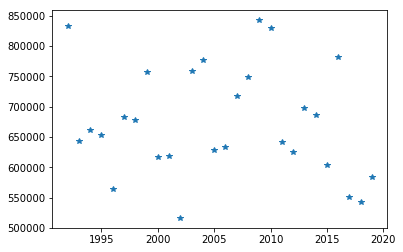

In [14]:
yearly_incidence.plot(style='*')

Une liste triée permet de plus facilement répérer les valeurs extrêmes.

In [15]:
yearly_incidence.sort_values()

2002    516689
2018    542312
2017    551041
1996    564901
2019    584066
2015    604382
2000    617597
2001    619041
2012    624573
2005    628464
2006    632833
2011    642368
1993    643387
1995    652478
1994    661409
1998    677775
1997    683434
2014    685769
2013    698332
2007    717352
2008    749478
1999    756456
2003    758363
2004    777388
2016    782114
2010    829911
1992    832939
2009    842373
dtype: int64

Enfin, un histogramme montre une queue de distribution assez épaisse : les épidémies fortes sont assez fréquentes ; d'un autre côté, elles ne sont pas beaucoup plus fortes qu'une épidémie moyenne.

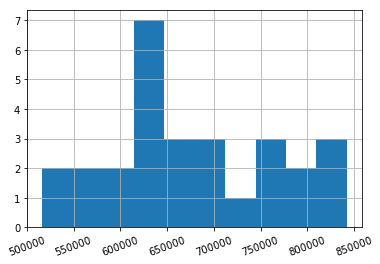

In [16]:
yearly_incidence.hist(xrot=20)

In [17]:
yearly_incidence.describe()

count        28.000000
mean     674186.607143
std       90193.127425
min      516689.000000
25%      618680.000000
50%      656943.500000
75%      751222.500000
max      842373.000000
dtype: float64